In [2]:
import pandas as pd
from sodapy import Socrata

# Example authenticated client (needed for non-public datasets):
client = Socrata("www.dallasopendata.com",
                  APPTOKEN
                  username="mwtichenor@gmail.com",
                  password=PWD)

results = client.get("ts5d-gdq6", limit=9999999)

client.close()

In [3]:
results_df = pd.DataFrame.from_records(results)
results_df.head()

,date,agenda_item_number,item_type,district,title,voter_name,vote,final_action_taken,agenda_item_description,agenda_id,vote_id
0,2020-04-01T00:00:00.000,1,AGENDA,7,Councilmember,Adam Bazaldua,YES,APPROVED,"Approval of Minutes of the March 4, 2020 City ...",040120_AG_1,040120_AG_1_7
1,2020-04-01T00:00:00.000,2,AGENDA,1,Councilmember,Chad West,YES,APPROVED,Consideration of appointments to boards and co...,040120_AG_2,040120_AG_2_1
2,2020-04-01T00:00:00.000,1,AGENDA,6,Councilmember,Omar Narvaez,YES,APPROVED,"Approval of Minutes of the March 4, 2020 City ...",040120_AG_1,040120_AG_1_6
3,2020-04-01T00:00:00.000,2,AGENDA,10,Deputy Mayor Pro Tem,B. Adam McGough,YES,APPROVED,Consideration of appointments to boards and co...,040120_AG_2,040120_AG_2_10
4,2020-04-01T00:00:00.000,1,AGENDA,9,Councilmember,Paula Blackmon,YES,APPROVED,"Approval of Minutes of the March 4, 2020 City ...",040120_AG_1,040120_AG_1_9


What's the time period for these agenda items?

In [4]:
results_df["date"].value_counts().sort_index()

2016-09-07T00:00:00.000      75
2016-09-14T00:00:00.000    1575
2016-09-21T00:00:00.000     135
2016-09-28T00:00:00.000    1065
2016-10-11T00:00:00.000     735
                           ... 
2020-02-26T00:00:00.000    1230
2020-03-04T00:00:00.000      30
2020-03-18T00:00:00.000      30
2020-03-25T00:00:00.000    1005
2020-04-01T00:00:00.000      30
Name: date, Length: 132, dtype: int64

How many agenda items are there?

In [5]:
results_df["agenda_id"].nunique()

4876

In [6]:
results_df = results_df.loc[:, ["agenda_id", "agenda_item_description"]].drop_duplicates()

Checkout a sample agenda.

In [7]:
results_df.iloc[369,1]

'Authorize a contract with Dallas Area Rapid Transit for the purchase of 300 annual passes in support of the City?s clean air initiative - Not to exceed $60,000.00 - Financing: General Fund (see Fiscal Information)'

## Data Preprocessing

In [8]:
agendas = results_df.iloc[:, 1].tolist()

In [9]:
from gensim.parsing.preprocessing import preprocess_string, strip_punctuation, strip_short
from gensim.parsing.preprocessing import strip_multiple_whitespaces, strip_numeric, remove_stopwords
import spacy

nlp = spacy.load("en_core_web_sm")

In [10]:
txt = agendas[311]
print(txt)

Authorize a professional services contract with The Kercher Group, Inc. to provide Pavement Management Consultant Services including pavement modeling evaluation, evaluation and review of current practices, quality management review of pavement condition data collection, and review of sidewalk and alley management practices - Not to exceed $232,431.58 - Financing: General Fund


In [11]:
txt = strip_punctuation(txt)
print(txt)

Authorize a professional services contract with The Kercher Group  Inc  to provide Pavement Management Consultant Services including pavement modeling evaluation  evaluation and review of current practices  quality management review of pavement condition data collection  and review of sidewalk and alley management practices   Not to exceed  232 431 58   Financing  General Fund


In [12]:
txt = strip_numeric(txt)
print(txt)

Authorize a professional services contract with The Kercher Group  Inc  to provide Pavement Management Consultant Services including pavement modeling evaluation  evaluation and review of current practices  quality management review of pavement condition data collection  and review of sidewalk and alley management practices   Not to exceed       Financing  General Fund


In [13]:
txt = remove_stopwords(txt)
print(txt)

Authorize professional services contract The Kercher Group Inc provide Pavement Management Consultant Services including pavement modeling evaluation evaluation review current practices quality management review pavement condition data collection review sidewalk alley management practices Not exceed Financing General Fund


In [14]:
doc = nlp(txt)
lemmatized = []
for token in doc:
    lemmatized.append(token.lemma_)

print(' '.join(lemmatized))

authorize professional service contract the Kercher Group Inc provide Pavement Management Consultant Services include pavement modeling evaluation evaluation review current practice quality management review pavement condition data collection review sidewalk alley management practice not exceed Financing General Fund


In [15]:
def spacy_lemmatize(x):
    doc = nlp(x)
    lemmas = []
    for token in doc:
        lemmas.append(token.lemma_)
    return ' '.join(lemmas)

CUSTOM_FILTERS = [lambda x: x.replace('�',"'"), strip_punctuation,
                  strip_numeric, remove_stopwords, spacy_lemmatize]

texts = [preprocess_string(agenda, CUSTOM_FILTERS) for agenda in agendas]

In [16]:
from gensim import corpora

dictionary = corpora.Dictionary(texts)

print(dictionary)

Dictionary(8879 unique tokens: ['Briefing', 'City', 'Council', 'March', 'Meeting']...)


In [17]:
corpus = [dictionary.doc2bow(text) for text in texts]

print(corpus[311])

[(17, 2), (31, 1), (33, 1), (34, 1), (36, 1), (40, 1), (48, 1), (58, 1), (105, 1), (107, 1), (120, 1), (185, 2), (202, 1), (267, 1), (296, 1), (298, 1), (456, 1), (484, 1), (633, 1), (918, 1), (974, 1), (1130, 3), (1342, 1), (1521, 1), (2158, 1), (2159, 1), (2160, 1), (2161, 1), (2162, 1), (2163, 2), (2164, 2), (2165, 1)]


In [18]:
for id, freq in corpus[311]:
    print((dictionary[id], freq))


('evaluation', 2)
('Financing', 1)
('Fund', 1)
('General', 1)
('Management', 1)
('Services', 1)
('authorize', 1)
('service', 1)
('exceed', 1)
('not', 1)
('Inc', 1)
('management', 2)
('provide', 1)
('condition', 1)
('contract', 1)
('professional', 1)
('Group', 1)
('include', 1)
('sidewalk', 1)
('data', 1)
('current', 1)
('review', 3)
('the', 1)
('alley', 1)
('Consultant', 1)
('Kercher', 1)
('Pavement', 1)
('collection', 1)
('modeling', 1)
('pavement', 2)
('practice', 2)
('quality', 1)


In [19]:
from gensim import models

tfidf = models.TfidfModel(corpus) 

corpus_tfidf = tfidf[corpus]

for id, freq in corpus_tfidf[311]:
    print((dictionary[id], freq))

('evaluation', 0.21188832614014183)
('Financing', 0.016646802680202903)
('Fund', 0.044295053902416365)
('General', 0.06491710719280125)
('Management', 0.09270150688005326)
('Services', 0.0750655765830837)
('authorize', 0.01725923117908318)
('service', 0.040430470045679914)
('exceed', 0.025757074065474835)
('not', 0.03128513839202381)
('Inc', 0.04836718575109044)
('management', 0.21145001794595045)
('provide', 0.05687813663445035)
('condition', 0.11019607756260195)
('contract', 0.04174615032119411)
('professional', 0.07893549473859429)
('Group', 0.09565157593957953)
('include', 0.0947351469883799)
('sidewalk', 0.14309151313956292)
('data', 0.17963275363657077)
('current', 0.09927890634302312)
('review', 0.4594948385188758)
('the', 0.1055074722640264)
('alley', 0.12962806123343126)
('Consultant', 0.250313331169163)
('Kercher', 0.250313331169163)
('Pavement', 0.1855477411716934)
('collection', 0.108230276587271)
('modeling', 0.250313331169163)
('pavement', 0.34941730471224186)
('practice'

In [20]:
from gensim.models.coherencemodel import CoherenceModel

topics = list(range(1, 21))
scores = []

for t in topics:
    lsi = models.LsiModel(corpus_tfidf, num_topics = t, id2word=dictionary)
    #corpus_lsi = lsi[corpus_tfidf]
    lsitopics = lsi.show_topics(formatted=False)
    lsitopics = [[word for word, prob in topic] for topicid, topic in lsitopics]
    cm = CoherenceModel(topics = lsitopics, 
                    texts = texts,
                    dictionary=dictionary)
    score = cm.get_coherence()
    scores.append(score)
    print("Num Topics: ", t, "; C_V: ", score)

Num Topics:  1 ; C_V:  0.9423819545540073
Num Topics:  2 ; C_V:  0.9692570526074304
Num Topics:  3 ; C_V:  0.9319444923447361
Num Topics:  4 ; C_V:  0.8574558178602345
Num Topics:  5 ; C_V:  0.8439460170873525
Num Topics:  6 ; C_V:  0.8168833047381282
Num Topics:  7 ; C_V:  0.7524731931706611
Num Topics:  8 ; C_V:  0.706254333584823
Num Topics:  9 ; C_V:  0.7243204673958691
Num Topics:  10 ; C_V:  0.7429322504058501
Num Topics:  11 ; C_V:  0.692881189722807
Num Topics:  12 ; C_V:  0.6942228039462776
Num Topics:  13 ; C_V:  0.6596754020784693
Num Topics:  14 ; C_V:  0.6400462228576865
Num Topics:  15 ; C_V:  0.6275913723576626
Num Topics:  16 ; C_V:  0.6387010791059495
Num Topics:  17 ; C_V:  0.6262516441040971
Num Topics:  18 ; C_V:  0.6105074681482467
Num Topics:  19 ; C_V:  0.6122336156088535
Num Topics:  20 ; C_V:  0.6201094745883097


In [21]:
from gensim.models.nmf import Nmf

nmf_scores = []

for t in topics:
    nmf = Nmf(corpus_tfidf, num_topics = t, id2word=dictionary, random_state = 13)
    #corpus_lsi = lsi[corpus_tfidf]
    nmftopics = nmf.show_topics(formatted=False)
    nmftopics = [[word for word, prob in topic] for topicid, topic in nmftopics]
    cm = CoherenceModel(topics = nmftopics, 
                    texts = texts,
                    dictionary=dictionary)
    nmf_score = cm.get_coherence()
    nmf_scores.append(nmf_score)
    print("Num Topics: ", t, "; C_V: ", nmf_score)

Num Topics:  1 ; C_V:  0.6996830388125176
Num Topics:  2 ; C_V:  0.8892586925618635
Num Topics:  3 ; C_V:  0.6581959997575711
Num Topics:  4 ; C_V:  0.6823594822945948
Num Topics:  5 ; C_V:  0.8116965801849447
Num Topics:  6 ; C_V:  0.5170436007219237
Num Topics:  7 ; C_V:  0.6595474862507668
Num Topics:  8 ; C_V:  0.6876437787899712
Num Topics:  9 ; C_V:  0.8149177040636931
Num Topics:  10 ; C_V:  0.8134370996697593
Num Topics:  11 ; C_V:  0.7484645112502315
Num Topics:  12 ; C_V:  0.7183086990849488
Num Topics:  13 ; C_V:  0.8324351626570305
Num Topics:  14 ; C_V:  0.7900520808117295
Num Topics:  15 ; C_V:  0.7670308363206224
Num Topics:  16 ; C_V:  0.6674429562416591
Num Topics:  17 ; C_V:  0.7375366189938563
Num Topics:  18 ; C_V:  0.6634263882166842
Num Topics:  19 ; C_V:  0.7501699902981339
Num Topics:  20 ; C_V:  0.769014693921935


In [22]:
from gensim.models.ldamodel import LdaModel

lda_scores = []

for t in topics:
    lda = LdaModel(corpus, num_topics = t, id2word=dictionary, random_state = 13)
    #corpus_lsi = lsi[corpus_tfidf]
    ldatopics = lda.show_topics(formatted=False)
    ldatopics = [[word for word, prob in topic] for topicid, topic in ldatopics]
    cm = CoherenceModel(topics = ldatopics, 
                    texts = texts,
                    dictionary=dictionary)
    lda_score = cm.get_coherence()
    lda_scores.append(lda_score)
    print("Num Topics: ", t, "; C_V: ", lda_score)

Num Topics:  1 ; C_V:  0.4042799605610073
Num Topics:  2 ; C_V:  0.7560824127942687
Num Topics:  3 ; C_V:  0.7518613405828255
Num Topics:  4 ; C_V:  0.669377564247603
Num Topics:  5 ; C_V:  0.5980828328210164
Num Topics:  6 ; C_V:  0.6642414208074904
Num Topics:  7 ; C_V:  0.7326193718844076
Num Topics:  8 ; C_V:  0.7049719693535652
Num Topics:  9 ; C_V:  0.6794860978009716
Num Topics:  10 ; C_V:  0.7297011696080853
Num Topics:  11 ; C_V:  0.7138656594412727
Num Topics:  12 ; C_V:  0.6898322028609429
Num Topics:  13 ; C_V:  0.7199955193634396
Num Topics:  14 ; C_V:  0.7488066727414924
Num Topics:  15 ; C_V:  0.7207604604858799
Num Topics:  16 ; C_V:  0.6933964862763665
Num Topics:  17 ; C_V:  0.7267984114079085
Num Topics:  18 ; C_V:  0.7306731508304599
Num Topics:  19 ; C_V:  0.7684368515417641
Num Topics:  20 ; C_V:  0.7710192181628245


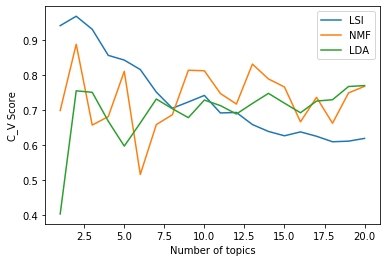

In [23]:
%matplotlib inline

from matplotlib import pyplot as plt
plt.plot(topics, scores, label = "LSI")
plt.plot(topics, nmf_scores, label = "NMF")
plt.plot(topics, lda_scores, label = "LDA")
plt.ylabel("C_V Score")
plt.xlabel("Number of topics")
plt.legend()
plt.show()

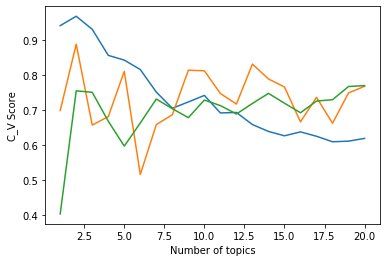

In [35]:
from matplotlib import pyplot as plt
plt.plot(topics, scores, label = "LSI")
plt.plot(topics, nmf_scores, label = "NMF")
plt.plot(topics, lda_scores, label = "LDA")
plt.ylabel("C_V Score")
plt.xlabel("Number of topics")
plt.savefig(r"C:\Users\mwtichen\Documents\Python Scripts\Dallas Agendas\model_comparison.png")

In [24]:
NUM = 2

lsi = models.LsiModel(corpus_tfidf, num_topics = NUM, id2word=dictionary)
corpus_lsi = lsi[corpus_tfidf]
lsi.show_topics()

[(0,
  '0.333*"District" + 0.169*"public" + 0.166*"hearing" + 0.165*"property" + 0.162*"ordinance" + 0.157*"application" + 0.156*"comment" + 0.155*"a" + 0.154*"zone" + 0.152*"receive"'),
 (1,
  '0.475*"commission" + 0.469*"board" + 0.241*"duties" + 0.239*"appointment" + 0.236*"evaluation" + 0.236*"nominee" + 0.231*"available" + 0.230*"member" + 0.221*"Secretary" + 0.206*"list"')]

In [25]:
import numpy as np
from gensim.matutils import corpus2dense

coprus_lsi_mat = corpus2dense(corpus_lsi, 2)

In [26]:
coprus_lsi_mat.shape

(2, 4876)

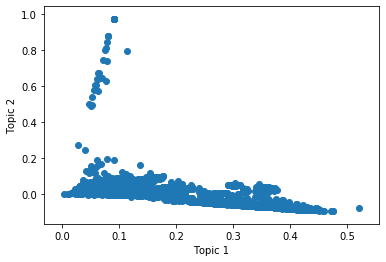

In [27]:
plt.scatter(coprus_lsi_mat[0, :], coprus_lsi_mat[1, :]) 
plt.xlabel("Topic 1")
plt.ylabel("Topic 2")
plt.show()

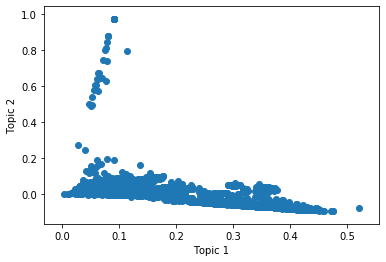

In [34]:
plt.scatter(coprus_lsi_mat[0, :], coprus_lsi_mat[1, :]) 
plt.xlabel("Topic 1")
plt.ylabel("Topic 2")
plt.savefig(r"C:\Users\mwtichen\Documents\Python Scripts\Dallas Agendas\doc_topic_plot.png")

In [28]:
np.argmax(coprus_lsi_mat[0, :])

3622

In [29]:
agendas[3622]

'A public hearing to receive comments regarding an application for and (1) an ordinance granting a TH-2(A) Townhouse District on property zoned Planned Development District No. 624 and an R-7.5(A) Single Family District; (2) an ordinance granting an MF-2(A) Multifamily District on property zoned Planned Development District No. 624; (3) an ordinance granting a CR Community Retail District on property zoned Planned Development District No. 624 and an R-7.5(A) Single Family District; (4) an ordinance granting an MF-3(A) Multifamily District on property zoned Planned Development District No. 624, an R-7.5(A) Single Family District, and a CR Community Retail District; (5) an ordinance granting a CR Community Retail District on property zoned an NS(A) Neighborhood Service District; (6) an ordinance granting an MF-3(A) Multifamily District on property zoned an R-7.5(A) Single Family District; (7) an ordinance granting an MF-2(A) Multifamily District on property zoned an R-7.5(A) Single Famil

In [32]:
np.argmax(coprus_lsi_mat[1, :])

1

In [33]:
agendas[1]

"Consideration of appointments to boards and commissions and the evaluation and duties of board and commission members (List of nominees is available in the City Secretary's Office)"